In [5]:
from os.path import join
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import utils

In [13]:
class SpatialDataset(Dataset):
    def __init__(self, inputs, outputs,device=utils.set_torch_device()):
        n_locs = inputs.shape[0] # number of (x,y) positions.
        n_contexts = outputs.shape[1]
        context_onehots = torch.eye(n_contexts,device=device).float()
        self.outputs = outputs.T.ravel().reshape(-1,1).float()
        self.inputs = inputs.repeat_interleave(n_contexts, dim=0)
        self.contexts = context_onehots.repeat_interleave(n_locs, dim=0)


    def __len__(self):
        return len(self.inputs)


    def __getitem__(self, idx):
        return self.inputs[idx], self.contexts[idx], self.outputs[idx]    

class SpatialModel(nn.Module):
    def __init__(self, n_contexts=100, device=utils.set_torch_device()):
        super().__init__()
        self.device = device
        self.ctxt_ind = nn.Linear(2, 128,device=self.device)
        self.ctxt = nn.Linear(n_contexts, 128, bias=False,device=self.device)
        self.ctxt_dep = nn.Linear(256, 128,device=self.device)
        self.out = nn.Linear(128, 1,device=self.device)


    def forward(self, x, context):
        ctxt_indep_rep = F.relu(self.ctxt_ind(x))
        ctxt_rep = F.relu(self.ctxt(context))
        ctxt_dep_rep = F.relu(self.ctxt_dep(torch.hstack([ctxt_indep_rep, ctxt_rep])))
        return torch.sigmoid(self.out(ctxt_dep_rep))
 
    
    def loss(self, out, ys):
        return F.mse_loss(out, ys)


def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (xs, tcs, ys) in enumerate(train_loader):
        optimizer.zero_grad()
        out = model(xs, tcs)
        loss = model.loss(out, ys)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader.dataset)
    return train_loss


def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (xs, tcs, ys) in enumerate(test_loader):
            out = model(xs, tcs)
            loss = model.loss(out, ys)
            test_loss += loss.item()
        test_loss /= len(test_loader.dataset)
    return test_loss


def setup(n_contexts=10, batch_size=1024, lr=1e-3, device=utils.set_torch_device(), use_gpu=True):
    inputs = torch.load('../data/spatial_inputs.pt',map_location=device)
    outputs = torch.load('../data/spatial_outputs.pt',map_location=device)[:, :n_contexts]
    train_dataset = SpatialDataset(inputs, outputs)
    train_loader = train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    #### COULD SET UP TEST DATASET HERE ####
    model = SpatialModel(n_contexts=n_contexts, device=device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return model, train_loader, optimizer

In [15]:
# Setup the environment.
model, train_loader, optimizer = setup(lr=.005)

nepochs = 1
log_interval = 100
train_losses = torch.zeros([nepochs])
for iepoch in range(nepochs):
    train_loss = train(model, train_loader, optimizer)
    train_losses[iepoch] = train_loss
    if iepoch%log_interval==0:
        print(f'Epoch {iepoch} train set average loss: {train_loss:.8f}')

Epoch 0 train set average loss: 0.00005616


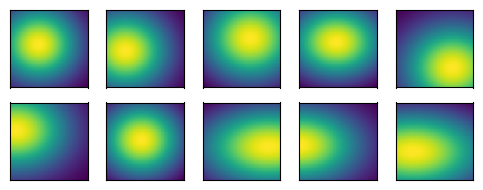

In [17]:
import matplotlib.pyplot as plt

# Visualize the contexts that you trained on.
n_contexts = 10
train_resources = train_loader.dataset[:][2].reshape(n_contexts,100,100)
fig, axes = plt.subplots(2, 5, tight_layout=True, sharex=True, sharey=True, figsize=(5,2))
for grad, ax in zip(train_resources, axes.ravel()):
    ax.imshow(grad.cpu(), interpolation='none')
    ax.set_yticks([])
    ax.set_xticks([])

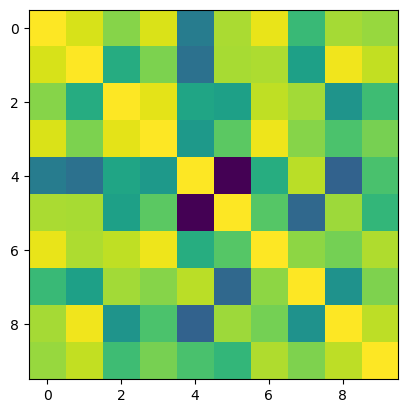

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(train_resources.cpu().reshape(n_contexts,-1))
plt.imshow(sim)